# Homework 6

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Generate-CoM-time-evolution-data" data-toc-modified-id="Generate-CoM-time-evolution-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate CoM time evolution data</a></span></li><li><span><a href="#Time-evolution-setup" data-toc-modified-id="Time-evolution-setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Time evolution setup</a></span></li><li><span><a href="#Relative-motion-plots:-Matplotlib" data-toc-modified-id="Relative-motion-plots:-Matplotlib-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Relative motion plots: Matplotlib</a></span></li><li><span><a href="#Relative-motion-plots:-Plotly-(for-interactivity)" data-toc-modified-id="Relative-motion-plots:-Plotly-(for-interactivity)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Relative motion plots: Plotly (for interactivity)</a></span></li><li><span><a href="#3D-plots,-M31-MW" data-toc-modified-id="3D-plots,-M31-MW-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>3D plots, M31-MW</a></span></li><li><span><a href="#Relative-velocity-and-separation" data-toc-modified-id="Relative-velocity-and-separation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Relative velocity and separation</a></span></li><li><span><a href="#M33-M31-orbit-decay" data-toc-modified-id="M33-M31-orbit-decay-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>M33-M31 orbit decay</a></span></li></ul></div>

## Setup

In [112]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G
from numpy.linalg import norm

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams

%matplotlib inline

In [3]:
# my modules
from galaxy.galaxy import Galaxy
# Step 1: modify CenterOfMass so that COM_P now takes a parameter specifying 
# by how much to decrease RMAX instead of a factor of 2
from galaxy.centerofmass import CenterOfMass

Start by finding out what we're dealing with in terms of particle numbers:

In [4]:
from galaxy.galaxies import Galaxies

g_small = Galaxies(datadir='./VLowRes')
g_small.get_counts_pivot()

typename,1 Halo,2 Disk,3 Bulge,All
name,,,,
M31,25000,60000,9500,94500
M33,5000,9300,0,14300
MW,25000,37500,5000,67500
All,55000,106800,14500,176300


## Generate CoM time evolution data

In [84]:
def orbit_com(galname, start, end, n, datadir='.', show_progress=True):
    """
    function that loops over all the desired snapshots to compute the COM pos and vel as a function of time.
    inputs:
          
    returns: 
    """
    
    # compose the filename for output
    fileout = f'./orbit_{galname}.txt'
    
    #  set tolerance and vol_dec for calculating COM_P in CenterOfMass
    # for M33 that is stripped more, use different values for vol_dec
    if galname == 'M33':
        delta = 0.1
        vol_dec = 4
    else:
        delta = 0.2
        vol_dec = 2
    
    # generate the snapshot id sequence 
    # it is always a good idea to also check if the input is eligible (not required)
    snap_ids = np.arange(start, end, n)
    
    # initialize the array for orbital info: t, x, y, z, vx, vy, vz of COM
    orbit = np.zeros((len(snap_ids), 7))
    
    print(galname)
    
    for  i, snap in enumerate(snap_ids): # loop over files
        gal = Galaxy(galname, snap, datadir=datadir)
        
        # Initialize an instance of CenterOfMass class, using disk particles
        com = CenterOfMass(gal)

        # Store the COM pos and vel. Remember that now COM_P required VolDec
        com_p = com.com_p(delta, vol_dec)
        com_v = com.com_v(com_p)
    
        # store the time, pos, vel in ith element of the orbit array,  without units (.value) 
        orbit[i] = gal.time.value/1000, *tuple(com_p.value), *tuple(com_v.value)
        
        # print snap_id to see the progress
        if show_progress:
            print(snap, end=' ')
    print('\nDone')
        
    # write the data to a file
    # we do this because we don't want to have to repeat this process 
    # this code should only have to be called once per galaxy.
    np.savetxt(fileout, orbit, fmt = "%11.3f"*7, comments='#',
               header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                      .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))

In [85]:
galnames = ('MW', 'M31', 'M33')

In [267]:
# Recover the orbits and generate the COM files for each galaxy
# read in 800 snapshots in intervals of n=5

# loop commented out to avoid accidentally rerunning this slow step

# for galname in galnames:
#     gal = Galaxy('M33', datadir='./VLowRes')
#     com = CenterOfMass(gal)
#     orbit_com(galname, 0, 800, 1, datadir='./VLowRes')

## Time evolution setup

In [92]:
# Read in the data files for the orbits of each galaxy that you just created
# headers:  t, x, y, z, vx, vy, vz
# using np.genfromtxt

orbits = {}
pos = {}
vel = {}
for galname in galnames:
    fname = f'./orbit_{galname}.txt'
    with open(fname) as file:
        orbits[galname] = np.genfromtxt(fname, dtype=None, names=True)
    pos[galname] = np.array([orbits[galname][xi] for xi in ('x','y','z')])
    vel[galname] = np.array([orbits[galname][vxi] for vxi in ('vx','vy','vz')])    
elapsed_time = orbits['M33']['t']

In [105]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  

def vec_diff(vec1, vec2, axis=None):
    if axis is None:
        assert len(vec1) == len(vec2)
        return norm(vec1 - vec2)
    else:
        assert vec1.shape == vec2.shape
        return norm(vec1 - vec2, axis=axis)

In [106]:
# Determine the magnitude of the relative position and velocities 

# of MW and M31
pos_MW_M31 = vec_diff(pos['MW'], pos['M31'], axis=0)
vel_MW_M31 = vec_diff(vel['MW'], vel['M31'], axis=0)

# of M33 and M31
pos_M33_M31 = vec_diff(pos['M33'], pos['M31'], axis=0)
vel_M33_M31 = vec_diff(vel['M33'], vel['M31'], axis=0)

## Relative motion plots: Matplotlib

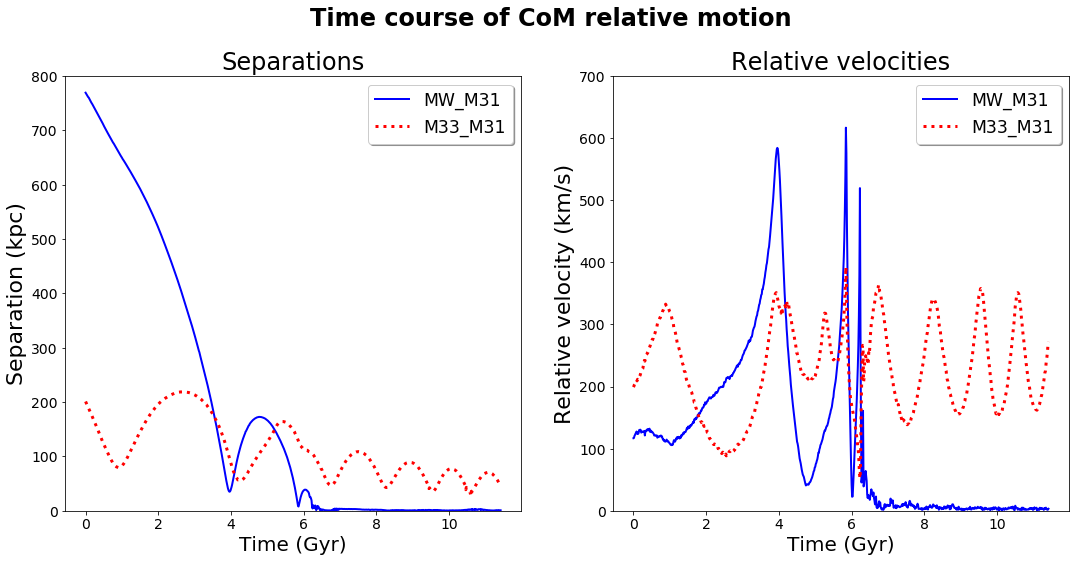

In [123]:
# Plot the Orbit of the galaxies 
#################################

fig = plt.figure(figsize=(18,8))
subplots = (121, 122)

# set up the left subplot
ax0 = plt.subplot(121)

# add the curves
ax0.plot(elapsed_time, pos_MW_M31, 'b-', lw=2, label='MW_M31')
ax0.plot(elapsed_time, pos_M33_M31, 'r:', lw=3, label='M33_M31')

# Add labels and subplot title
ax0.set_xlabel('Time (Gyr)', fontsize=20)
ax0.set_ylabel('Separation (kpc)', fontsize=22)
ax0.legend(loc='upper right',fontsize='xx-large', shadow=True)
ax0.set_title('Separations', fontsize=24)

#set axis limits
ax0.set_ylim(0, 800)

# set up the right subplot
ax1 = plt.subplot(122)

# add the curves
ax1.plot(elapsed_time, vel_MW_M31, 'b-', lw=2, label='MW_M31')
ax1.plot(elapsed_time, vel_M33_M31, 'r:', lw=3, label='M33_M31')

#adjust tick label font size
label_size = 14
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels and subplot title
ax1.set_xlabel('Time (Gyr)', fontsize=20)
ax1.set_ylabel('Relative velocity (km/s)', fontsize=22)
ax1.legend(loc='upper right',fontsize='xx-large', shadow=True)
ax1.set_title('Relative velocities', fontsize=24)

#set axis limits
ax1.set_ylim(0, 700)

# Overall title
fig.suptitle(f'Time course of CoM relative motion', y=1.0, fontsize=24, weight='bold');

## Relative motion plots: Plotly (for interactivity)

We need to start with some more imports, then get everything into some appropriate Pandas dataframes.

In [125]:
import pandas as pd
import plotly.express as px

In [177]:
MW_M31 = pd.DataFrame()
MW_M31['t_Gyr'] = elapsed_time
MW_M31['sep_kpc'] = pos_MW_M31
MW_M31['vel_km_s'] = vel_MW_M31
MW_M31['x_sep_kpc'] = orbits['M31']['x'] - orbits['MW']['x']
MW_M31['y_sep_kpc'] = orbits['M31']['y'] - orbits['MW']['y']
MW_M31['z_sep_kpc'] = orbits['M31']['z'] - orbits['MW']['z']

In [178]:
M31_M33 = pd.DataFrame()
M31_M33['t_Gyr'] = elapsed_time
M31_M33['sep_kpc'] = pos_M33_M31
M31_M33['vel_km_s'] = vel_M33_M31
M31_M33['x_sep_kpc'] = orbits['M33']['x'] - orbits['M31']['x']
M31_M33['y_sep_kpc'] = orbits['M33']['y'] - orbits['M31']['y']
M31_M33['z_sep_kpc'] = orbits['M33']['z'] - orbits['M31']['z']

Most of the work is in data prep. Plotting is then pretty simple.

In [179]:
d = px.line(MW_M31, x='t_Gyr', y='sep_kpc')
d.update_layout(
    title="M31 relative to MW, separation vs time",
    font=dict(size=16)
)
d.show()

In [180]:
d5 = px.line(M31_M33, x='t_Gyr', y='sep_kpc')
d5.update_layout(
    title="M33 relative to M31, separation vs time",
    font=dict(size=16)
)
d5.show()

## 3D plots, M31-MW

Both plots below show the MW-centric separation in Cartesian coordinates. They only differ in color-coding, using time then distance.

The plots are highly interactive: use the mouse.

In [170]:
MW_M31_late = MW_M31[MW_M31['t_Gyr']>3.5]
d2 = px.scatter_3d(MW_M31_late, x='x_sep_kpc', y='y_sep_kpc', z='z_sep_kpc', color='t_Gyr',
                 width=800, height=800)
d2.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
d2.update_layout(
    title="M31 relative to MW, colored by elapsed time (>3.5 Gyr)",
    font=dict(size=16)
)

d2.show()

In [171]:
d3 = px.scatter_3d(MW_M31_late, x='x_sep_kpc', y='y_sep_kpc', z='z_sep_kpc', color='sep_kpc',
                 width=800, height=800)
d3.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
d3.update_layout(
    title="M31 relative to MW, colored by separation distance",
    font=dict(size=16)
)

d3.show()

## Relative velocity and separation

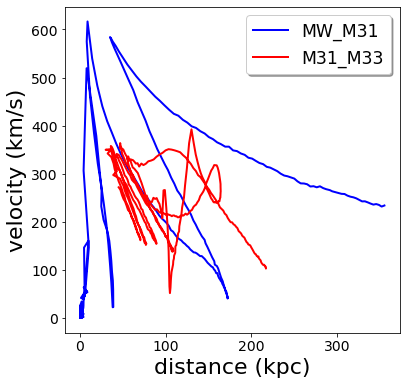

In [280]:
plt.figure(figsize=(6,6))
ignore_start = 200
plt.plot(pos_MW_M31[ignore_start:], vel_MW_M31[ignore_start:], 'b-', lw=2, label='MW_M31')
plt.plot(pos_M33_M31[ignore_start:], vel_M33_M31[ignore_start:], 'r-', lw=2, label='M31_M33')
plt.xlabel('distance (kpc)', fontsize=22)
plt.ylabel('velocity (km/s)', fontsize=22)
plt.legend(loc='upper right',fontsize='xx-large', shadow=True);

## M33-M31 orbit decay

Start by getting lists of apocenters:

In [226]:
t_apo = [2.657, 5.414, 7.50, 8.914, 10.057, 11.057]
periods = [t_apo[i+1] - t_apo[i] for i in range(len(t_apo) - 1)]
peak_indices = [np.where(elapsed_time==t)[0][0] for t in t_apo]
r_apo = pos_M33_M31[peak_indices]

Plot separation vs time and velocity vs time:

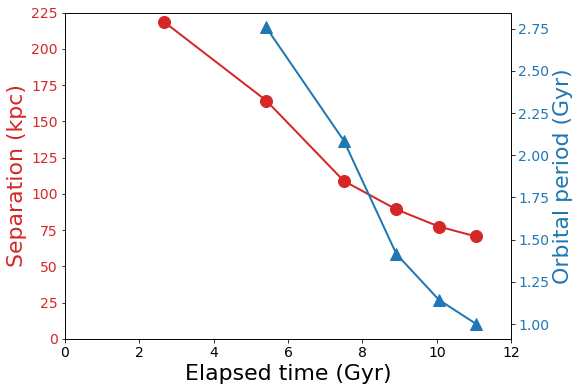

In [288]:
fig, ax1 = plt.subplots(figsize=(8,6))

# plot distances
color = 'tab:red'
ax1.set_xlabel('Elapsed time (Gyr)', fontsize=22)
ax1.set_ylabel('Separation (kpc)', color=color, fontsize=22)
ax1.plot(t_apo, r_apo, marker='o', ms=12, color=color, lw=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 225)

# plot orbital periods
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Orbital period (Gyr)', color=color, fontsize=22)
ax2.plot(t_apo[1:], periods, marker='^', color=color, ms=12, lw=2)
ax2.tick_params(axis='y', labelcolor=color)

#adjust tick label font size
label_size = 14
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size;

Expand the later timepoints:

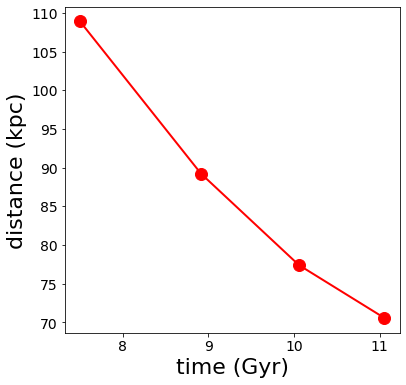

In [287]:
plt.figure(figsize=(6,6))
plt.plot(t_apo[2:], r_apo[2:], 'ro-', ms=12, lw=2)
# plt.ylim(0, 125)
plt.xlabel('time (Gyr)', fontsize=22)
plt.ylabel('distance (kpc)', fontsize=22);

Using just the last two points, estimate decay rate and time to merger:

In [262]:
decay_rate = -(r_apo[-2] - r_apo[-1]) / (t_apo[-2] - t_apo[-1]) * u.kpc/u.Gyr
decay_rate

<Quantity 6.84378753 kpc / Gyr>

In [265]:
75*u.kpc / decay_rate

<Quantity 10.95884402 Gyr>